# Previsión de falla 

## Carregamento e pretratamento dos dados

In [50]:
import pandas as pd

data = pd.read_csv("full_devices.csv", encoding="ISO-8859-1", parse_dates=["date"]).sort_values(by=["device", "date"])

É necessário fazer algumas operações sobre esses dados para obter as features de entrada e o target. Identificada a falta de dados para alguns dias, fazemos o resampling diário dos dados, e o shift da coluna target. Como existem dados faltantes, e eles não são dados com target=1 (falha no dia seguinte), eles foram desconsiderados.

In [51]:
def process_group(group: pd.DataFrame) -> pd.DataFrame:
    group = group.set_index("date").resample("D").max()
    group.loc[:, "target"] = group["failure"].shift(-1)
    return group

resampled_group = data.groupby('device').apply(process_group).dropna(how="any").reset_index(drop=True)
resampled_group 

C:\Users\jeh_m\AppData\Local\Temp\ipykernel_39180\3094842715.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resampled_group = data.groupby('device').apply(process_group).dropna(how="any").reset_index(drop=True)


,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,target
0,S1F01085,0.0,215630672.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,0.0
1,S1F01085,0.0,1650864.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,0.0
2,S1F01085,0.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0,7.0,0.0
3,S1F01085,0.0,128073224.0,56.0,0.0,52.0,6.0,407439.0,0.0,0.0,7.0,0.0
4,S1F01085,0.0,97393448.0,56.0,0.0,52.0,6.0,408114.0,0.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
123099,Z1F2PBHX,0.0,232559640.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,0.0,0.0
123100,Z1F2PBHX,0.0,180917784.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,0.0,0.0
123101,Z1F2PBHX,0.0,33952520.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,0.0,0.0
123102,Z1F2PBHX,0.0,59053184.0,0.0,0.0,0.0,5.0,162645.0,0.0,0.0,0.0,0.0


Selecionando os dados de entrata e particionando-os em conjunto de treino e test:

In [52]:
from sklearn import model_selection

train_cols = [
    "failure",
    "attribute1",
    "attribute2",
    "attribute3",
    "attribute4",
    "attribute5",
    "attribute6",
    "attribute7",
    "attribute8",
    "attribute9",
]

x, y = resampled_group[train_cols], resampled_group["target"]
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x, y, test_size=0.3, random_state=42
)

Normalizando as features de entrada, já que possuem distribuições significativamente diferentes:

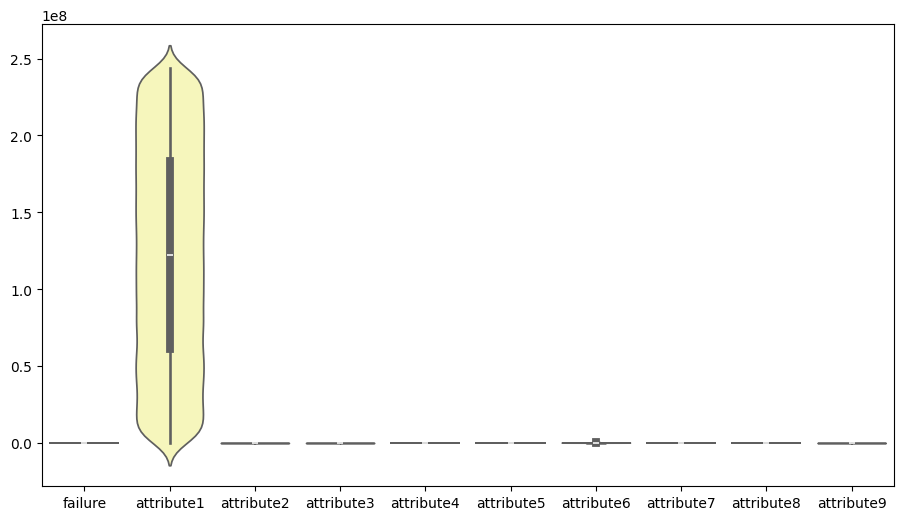

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=x_train, palette="Set3")
plt.show()

In [54]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

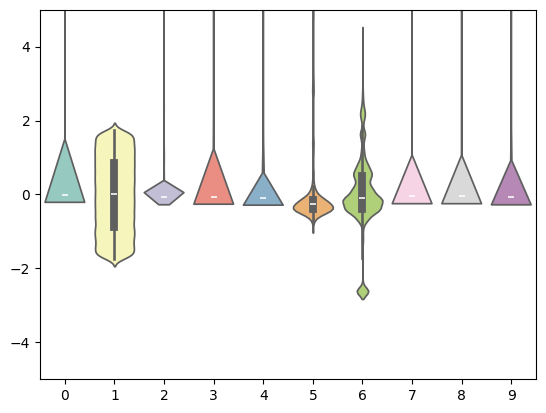

In [55]:
fig, ax = plt.subplots(1,1)
sns.violinplot(data=x_train, palette="Set3")
ax.set_ylim(bottom=-5, top=5)
plt.show()

Analisando a distribuição de dados de falha e não falha para os dois datasets, percebemos que se trata de um problema fortemente desbalanceado:

In [56]:
import numpy as np
print(f"Dados de falha no dataset de treino: {np.count_nonzero(y_train)}/{len(y_train)}")
print(f"Dados de falha no dataset de teste: {np.count_nonzero(y_test)}/{len(y_test)}")

Dados de falha no dataset de treino: 68/86172
Dados de falha no dataset de teste: 36/36932


Usando a técnica de oversampling para balancear as classes no conjunto de treinamento temos:

In [57]:
from collections import Counter
from imblearn import over_sampling

sm = over_sampling.SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)
print('Distribuição do dataset rebalanceado: %s' % Counter(y_res))

Distribuição do dataset rebalanceado: Counter({0.0: 86104, 1.0: 86104})


## Treino e avaliação do modelo

O modelo escolhido é um classificador Random Forest com 100 estimadores.

In [58]:
from sklearn import ensemble
from sklearn import metrics

rf_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_res, y_res)

y_pred = rf_classifier.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     36896
         1.0       0.04      0.06      0.05        36

    accuracy                           1.00     36932
   macro avg       0.52      0.53      0.52     36932
weighted avg       1.00      1.00      1.00     36932



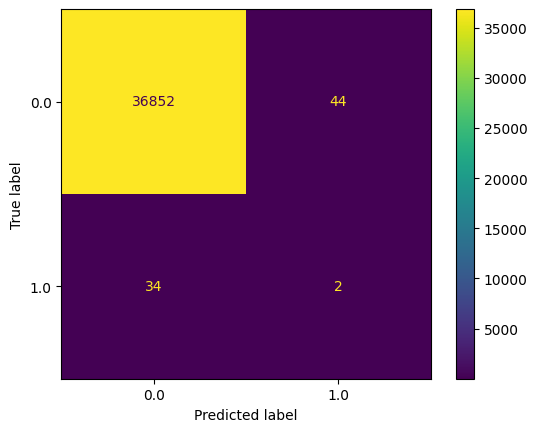

In [59]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_test, y_pred),
    display_labels=rf_classifier.classes_,
)
disp.plot()

Os resultados mostram que apesar da aplicação da técnica de oversampling, o modelo tem dificuldade para identificar falhas no dataset de teste, provavelmente devido a pouca representatividade dos dados de falha no dataset de treino. Testes com modelos como XGBoost e SVM tiveram resultados semelhantes, indicando pouca eficácia em aumentar complexidade do modelo. Para melhorar esses resultados, minha sugestão seria aprofundar a análise das variáveis de entrada, ou seja, realizando feature engineering. Os resultados de probabilidade de falha para esse modelo são obtidos através do código a seguir:

In [60]:
x_prob = rf_classifier.predict_proba(x_test)[:,1]